# Hands-on GNN-based models for User Profiling (1/2) - **CatGCN**

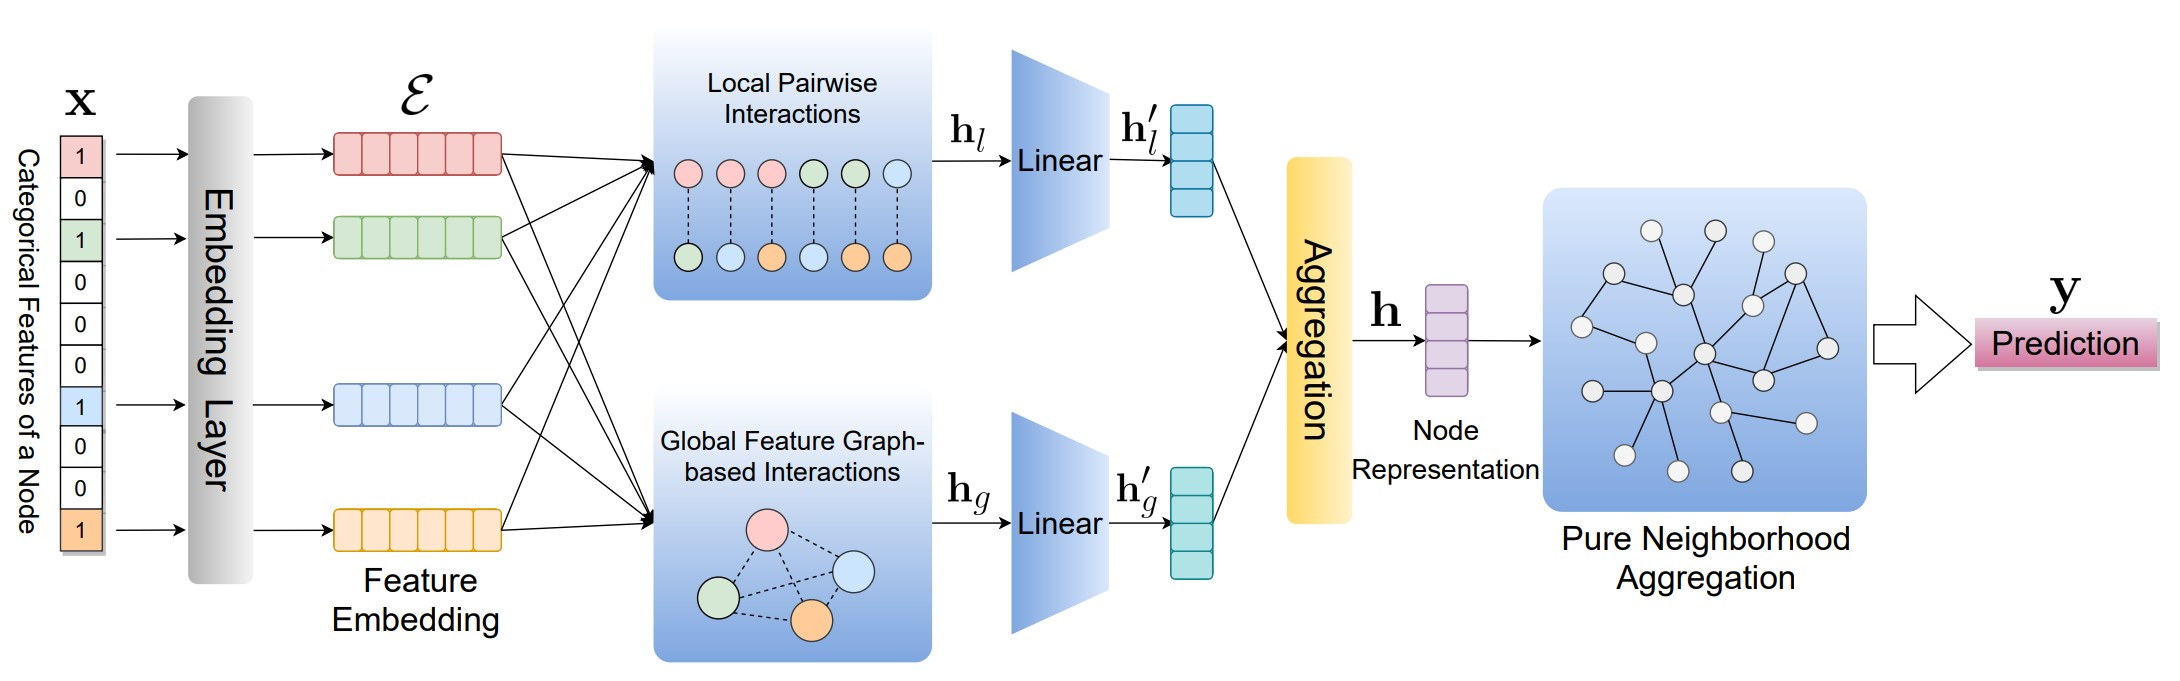

**CatGCN** [(Chen et al., 2021)](https://arxiv.org/pdf/2009.05303.pdf) is a *Graph Convolutional Network* (GCN) model tailored for graph learning on categorical node features.

This model enhances the initial node representation by integrating two types of explicit interaction modelling into its learning process: a local multiplication-based interaction on each pair of node features and a global addition-based interaction on an artificial feature graph.

The proposed method shows the effectiveness of performing feature interaction modelling before graph convolution.

---
## Get started

Let's prepare our **workspace**!

The material is included in the [GitHub repository](https://github.com/beyondaccuracy-userprofiling/tutorial-umap23) of the tutorial (expect for the raw datasets, due to upload limits of GitHub).

⭐ Star the repository if you are interested in this tutorial and its future updated versions.

To get started with the hands-on, follow these steps:

* Open the [Google Drive folder](https://drive.google.com/drive/folders/1bNDrHaqmvQH8iiNcbMnetYgcq6y3roGM?usp=sharing) containing all the needed resources;
* Click on the folder name (*Hands-on*) and select *Add shortcut to Drive*;
* On the left, go to **My Drive**, locate the *Hands-on* folder;
* Open the notebook named *1_CatGCN.ipynb* (and all the others for the next hands-on sessions);
* On the top, open the *Runtime* tab, click on *Change runtime type* and select **GPU** as the *Harware Acceleration*, to enable the execution of this notebook on a GPU (required for the GNN training).

### Mount the Drive

The first operation is to allow the notebook to access the hands-on files downloaded in your personal Google Drive folder.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now that you have your Google Drive mounted, let's set the base directory path as the tutorial's folder.

In [2]:
base_path = "/content/drive/MyDrive/Code/personal_projects/tutorial-umap23/Hands-on"

---
## Utilities

*Every operation will be described in order to make this tutorial also enjoyable by beginners and anyone not familiar with all the packages imported.*

⚠️⌛ The installation of `torch_scatter` requires ~12 minutes.

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import scipy.sparse as sp

# Install missing libraries in Colab
!pip3 install pymetis
!pip3 install torch_geometric
!pip3 install torch_scatter
!pip3 install texttable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.1/327.1 kB 7.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 12.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=c952cb6fabd0d03da9d66fe6f46b29e39444713d89a91264d15bd193906d75ee
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 4.2 MB/s eta 0:00:00
  Preparing me

Utilities to visualize the **information** and **statistics** of a *DataFrame*.

In [4]:
def show_df_info(df):
    print(df.info())
    print('####### Repeat ####### \n', df.duplicated().any())
    print('####### Count ####### \n', df.nunique())
    print('####### Example ####### \n',df.head())

In [5]:
def label_statics(label_df, label_list):
    print("####### nCount #######")
    for label in label_list:
        print(label_df[label].value_counts())
    print("####### nPercent #######")
    for label in label_list:
        print(label_df[label].value_counts()/label_df.shape[0])

---
## Alibaba dataset

[Alibaba dataset](https://tianchi.aliyun.com/dataset/56) contains click-through rates data about ads displayed on Alibaba's *Taobao* platform, and has been adopted in several paper, such as [Chen et al. (2021)](https://arxiv.org/pdf/2009.05303.pdf) and [Yan et al. (2021)](https://arxiv.org/pdf/2110.07181.pdf) for their experimental settings.

In this scenario, the **categories** of products are chosen as the *categorical features* affiliated to user nodes. Particularly, if one user has clicked product belonging to the category $i$, it results $x_i = 1$, otherwise $x_i = 0$.

#### Get raw Alibaba data path

In [6]:
raw_data_path = os.path.join(base_path, "datasets", "ali_data", "_raw_data")

### *User profile* data processing

#### Load user profile data

This dataset covers the basic information of 1060000 users in *raw_sample*. Description of the most relevant (and used) attributes:

* ***userid***: User ID ⇒ `uid`;
* ***final_gender_code***: gender 1 for *male*, 2 for *female* ⇒ `gender`;
* ***age_level***: 7-level attribute for age (without further details about the split) ⇒ `age`;
* ***pvalue_level***: Consumption grade, 1 for *low*, 2 for *mid*, 3 for *high* ⇒ `buy`;
* ***occupation***: Whether the user is a college student, 1 for *yes*, 0 for *no* ⇒ `student`;
* ***new_user_class_level***: level of the city where the user lives ⇒ `city`.

In [7]:
profiles = pd.read_csv(os.path.join(raw_data_path, 'user_profile.csv'), usecols=[0,3,4,5,7,8])
profiles.dropna(inplace=True)
profiles.rename(columns={'userid':'uid', 'final_gender_code':'gender','age_level':'age', 'pvalue_level':'buy', \
                        'occupation':'student', 'new_user_class_level ':'city'}, inplace=True)

In [8]:
show_df_info(profiles)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395932 entries, 1 to 1061767
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   uid      395932 non-null  int64  
 1   gender   395932 non-null  int64  
 2   age      395932 non-null  int64  
 3   buy      395932 non-null  float64
 4   student  395932 non-null  int64  
 5   city     395932 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 21.1 MB
None
####### Repeat ####### 
 False
####### Count ####### 
 uid        395932
gender          2
age             7
buy             3
student         2
city            4
dtype: int64
####### Example ####### 
     uid  gender  age  buy  student  city
1   523       2    2  1.0        1   2.0
5  3644       2    6  2.0        0   2.0
6  5777       2    5  2.0        0   2.0
8  6355       2    1  1.0        0   4.0
9  6823       2    5  2.0        0   1.0


In [9]:
label_statics(profiles, profiles.columns[1:])

####### nCount #######
2    269064
1    126868
Name: gender, dtype: int64
3    120071
4     94831
2     83409
5     73721
1     16734
6      7026
0       140
Name: age, dtype: int64
2.0    242292
1.0    121345
3.0     32295
Name: buy, dtype: int64
0    367856
1     28076
Name: student, dtype: int64
2.0    178624
3.0     96252
4.0     76959
1.0     44097
Name: city, dtype: int64
####### nPercent #######
2    0.679571
1    0.320429
Name: gender, dtype: float64
3    0.303262
4    0.239513
2    0.210665
5    0.186196
1    0.042265
6    0.017745
0    0.000354
Name: age, dtype: float64
2.0    0.611954
1.0    0.306479
3.0    0.081567
Name: buy, dtype: float64
0    0.929089
1    0.070911
Name: student, dtype: float64
2.0    0.451148
3.0    0.243102
4.0    0.194374
1.0    0.111375
Name: city, dtype: float64


#### Create `bin_age` attribute

In order to use the dataset within a binary user profiling scenario, we binarize the *age* label, in such a way to define a clear separation between the two obtained groups.

In [10]:
profiles['bin_age'] = profiles['age']
profiles['bin_age'] = profiles['bin_age'].replace(1,0)
profiles['bin_age'] = profiles['bin_age'].replace(2,0)
profiles['bin_age'] = profiles['bin_age'].replace(3,0)
profiles['bin_age'] = profiles['bin_age'].replace(4,1)
profiles['bin_age'] = profiles['bin_age'].replace(5,1)
profiles['bin_age'] = profiles['bin_age'].replace(6,1)

In [11]:
label_statics(profiles, profiles.columns[1:])

####### nCount #######
2    269064
1    126868
Name: gender, dtype: int64
3    120071
4     94831
2     83409
5     73721
1     16734
6      7026
0       140
Name: age, dtype: int64
2.0    242292
1.0    121345
3.0     32295
Name: buy, dtype: int64
0    367856
1     28076
Name: student, dtype: int64
2.0    178624
3.0     96252
4.0     76959
1.0     44097
Name: city, dtype: int64
0    220354
1    175578
Name: bin_age, dtype: int64
####### nPercent #######
2    0.679571
1    0.320429
Name: gender, dtype: float64
3    0.303262
4    0.239513
2    0.210665
5    0.186196
1    0.042265
6    0.017745
0    0.000354
Name: age, dtype: float64
2.0    0.611954
1.0    0.306479
3.0    0.081567
Name: buy, dtype: float64
0    0.929089
1    0.070911
Name: student, dtype: float64
2.0    0.451148
3.0    0.243102
4.0    0.194374
1.0    0.111375
Name: city, dtype: float64
0    0.556545
1    0.443455
Name: bin_age, dtype: float64


#### Create `bin_buy` attribute

We apply the same operation to the *buy* label (i.e. consumption grade) for either having a second target class (thus, the possibility to evaluate a different user profiling task) or to use one of the two labels as the *sensitive attribute* in a fairness assessment.

In [12]:
profiles['bin_buy'] = profiles['buy']
profiles['bin_buy'] = profiles['bin_buy'].replace(3.0, 2.0)
profiles['bin_buy'] = profiles['bin_buy'].astype('int64')

label_statics(profiles, profiles.columns[1:])

####### nCount #######
2    269064
1    126868
Name: gender, dtype: int64
3    120071
4     94831
2     83409
5     73721
1     16734
6      7026
0       140
Name: age, dtype: int64
2.0    242292
1.0    121345
3.0     32295
Name: buy, dtype: int64
0    367856
1     28076
Name: student, dtype: int64
2.0    178624
3.0     96252
4.0     76959
1.0     44097
Name: city, dtype: int64
0    220354
1    175578
Name: bin_age, dtype: int64
2    274587
1    121345
Name: bin_buy, dtype: int64
####### nPercent #######
2    0.679571
1    0.320429
Name: gender, dtype: float64
3    0.303262
4    0.239513
2    0.210665
5    0.186196
1    0.042265
6    0.017745
0    0.000354
Name: age, dtype: float64
2.0    0.611954
1.0    0.306479
3.0    0.081567
Name: buy, dtype: float64
0    0.929089
1    0.070911
Name: student, dtype: float64
2.0    0.451148
3.0    0.243102
4.0    0.194374
1.0    0.111375
Name: city, dtype: float64
0    0.556545
1    0.443455
Name: bin_age, dtype: float64
2    0.693521
1    0.306479


### *Ad_feature* data processing

This dataset covers the basic information of all ads in *raw_sample*. Description of the most relevant (and used) attributes:

* ***adgroup_id***: Ad ID ⇒ `pid`;
* ***cate_id***: item category ID ⇒ `cid`.

In [13]:
pid_cid = pd.read_csv(os.path.join(raw_data_path, 'ad_feature.csv'), usecols=['adgroup_id', 'cate_id'])
pid_cid.rename(columns={'adgroup_id':'pid','cate_id':'cid'}, inplace=True)

In [14]:
show_df_info(pid_cid)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846811 entries, 0 to 846810
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   pid     846811 non-null  int64
 1   cid     846811 non-null  int64
dtypes: int64(2)
memory usage: 12.9 MB
None
####### Repeat ####### 
 False
####### Count ####### 
 pid    846811
cid      6769
dtype: int64
####### Example ####### 
       pid   cid
0   63133  6406
1  313401  6406
2  248909   392
3  208458   392
4  110847  7211


### *Raw sample* data processing

Random sampled of 1140000 users from the website of Taobao for 8 days of ad display / click logs (26 million records) to form the original sample skeleton. Description of the most relevant (and used) attributes:

* ***user***: User ID ⇒ `uid`;
* ***adgroup_id***: adgroup ID ⇒ `pid`;
* ***clk***: 1 for *click*, 0 for *not click* ⇒ `clk`;

In [15]:
uid_pid = pd.read_csv(os.path.join(raw_data_path, 'raw_sample.csv'), usecols=['user', 'adgroup_id', 'clk'])
uid_pid.rename(columns={'user':'uid','adgroup_id':'pid'}, inplace=True)

uid_pid = uid_pid[uid_pid['clk']>0]

uid_pid.drop('clk', axis=1, inplace=True)

uid_pid = uid_pid[uid_pid['uid'].isin(profiles['uid'])]
uid_pid = uid_pid[uid_pid['pid'].isin(pid_cid['pid'])]

uid_pid.drop_duplicates(inplace=True)

In [16]:
show_df_info(uid_pid)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507112 entries, 92 to 26557931
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   uid     507112 non-null  int64
 1   pid     507112 non-null  int64
dtypes: int64(2)
memory usage: 11.6 MB
None
####### Repeat ####### 
 False
####### Count ####### 
 uid    180902
pid    144201
dtype: int64
####### Example ####### 
          uid  pid
92    642854  102
257   843732  102
283  1076956  102
300   358193  102
350  1002263  102


---
## Local Pairwise Interactions

Since in the **Alibaba dataset** there is no direct correlation, e.g. "follow", between users in the e-commerce platform, we establish the relationship between users based on ***co-click***.

In other words, if users jointly click the same product, we establish an edge between the two user nodes. Naturally, the edges between users established through this common behavior are undirected.

Due to the size of the dataset, we filter the interactions by means of the utilities defined below.

In [17]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=True)
    count = playcount_groupbyid.size()
    return count

In [18]:
def filter_triplets(tp, user, item, min_uc=0, min_sc=0):
    # Only keep the triplets for users who clicked on at least min_uc items
    if min_uc > 0:
        usercount = get_count(tp, user)
        tp = tp[tp[user].isin(usercount.index[usercount >= min_uc])]

    # Only keep the triplets for items which were clicked on by at least min_sc users.
    if min_sc > 0:
        itemcount = get_count(tp, item)
        tp = tp[tp[item].isin(itemcount.index[itemcount >= min_sc])]

    # Update both usercount and itemcount after filtering
    usercount, itemcount = get_count(tp, user), get_count(tp, item)
    return tp, usercount, itemcount

### Filter *user--product* interaction (`uid_pid`)

We keep only the **user-product** interactions where a product has been clicked at least twice by a user.

In [19]:
# Before filtering
users = set(uid_pid.uid.tolist())
items = set(uid_pid.pid.tolist())

print("Before filtering, there are %d users and %d items" % (len(users), len(items)))

Before filtering, there are 180902 users and 144201 items


In [20]:
uid_pid, uid_activity, pid_popularity = filter_triplets(uid_pid, 'uid', 'pid', min_uc=0, min_sc=2) # min_sc>=2

sparsity = 1. * uid_pid.shape[0] / (uid_activity.shape[0] * pid_popularity.shape[0])

print("After filtering, there are %d interacton events from %d users and %d items (sparsity: %.4f%%)" %
      (uid_pid.shape[0], uid_activity.shape[0], pid_popularity.shape[0], sparsity * 100))

After filtering, there are 427464 interacton events from 166958 users and 64553 items (sparsity: 0.0040%)


### Create *user--category* interaction (`uid_cid`)

Since there is no direct connection between users and product categories, we merge the DataFrames containing *user-product* and *product-category* interactions to create the **user-category** interaction DataFrame.

In [21]:
uid_pid_cid = pd.merge(uid_pid, pid_cid, how='inner', on='pid')
raw_uid_cid = uid_pid_cid.drop('pid', axis=1, inplace=False)
raw_uid_cid.drop_duplicates(inplace=True)

### Filter *user--category* interaction (`uid_cid`)

We filter the created resource in order to keep only the **user-category** interactions where a category has been clicked at least twice by a user.

In [22]:
uid_cid, uid_activity, cid_popularity = filter_triplets(raw_uid_cid, 'uid', 'cid', min_uc=0, min_sc=2) # min_sc>=2

sparsity = 1. * uid_cid.shape[0] / (uid_activity.shape[0] * cid_popularity.shape[0])

print("After filtering, there are %d interacton events from %d users and %d items (sparsity: %.4f%%)" %
      (uid_cid.shape[0], uid_activity.shape[0], cid_popularity.shape[0], sparsity * 100))

After filtering, there are 306057 interacton events from 166958 users and 2820 items (sparsity: 0.0650%)


### Create *user--user* interactions (`uid_uid`)

Finally, we use the available DataFrames to create the **user-user** local pairwise interactions.

In [23]:
uid_pid = uid_pid[uid_pid['uid'].isin(uid_cid['uid'])]

uid_pid_1 = uid_pid[['uid','pid']].copy()
uid_pid_1.rename(columns={'uid':'uid1'}, inplace=True)

uid_pid_2 = uid_pid[['uid','pid']].copy()
uid_pid_2.rename(columns={'uid':'uid2'}, inplace=True)

In [24]:
uid_pid_uid = pd.merge(uid_pid_1, uid_pid_2, how='inner', on='pid')
uid_uid = uid_pid_uid.drop('pid', axis=1, inplace=False)
uid_uid.drop_duplicates(inplace=True)

show_df_info(uid_uid)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29061406 entries, 0 to 29616698
Data columns (total 2 columns):
 #   Column  Dtype
---  ------  -----
 0   uid1    int64
 1   uid2    int64
dtypes: int64(2)
memory usage: 665.2 MB
None
####### Repeat ####### 
 False
####### Count ####### 
 uid1    166958
uid2    166958
dtype: int64
####### Example ####### 
      uid1     uid2
0  642854   642854
1  642854   843732
2  642854  1076956
3  642854   358193
4  642854  1002263


We delete the temporary useless files to have the

In [25]:
del uid_pid_1, uid_pid_2, uid_pid_uid

---
## Features mapping

To facilitate the classification, each features in the datasets are mapped with numerical values starting from 0.

In [26]:
user_label = profiles[profiles['uid'].isin(uid_cid['uid'])]

In [27]:
uid2id = {num: i for i, num in enumerate(user_label['uid'])}
cid2id = {num: i for i, num in enumerate(pd.unique(uid_cid['cid']))}

def col_map(df, col, num2id):
    df[[col]] = df[[col]].applymap(lambda x: num2id[x])
    return df

def label_map(label_df, label_list):
    for label in label_list:
        label2id = {num: i for i, num in enumerate(pd.unique(label_df[label]))}
        label_df = col_map(label_df, label, label2id)
    return label_df

In [28]:
label_statics(user_label, user_label.columns[1:])

####### nCount #######
2    124766
1     42192
Name: gender, dtype: int64
3    51467
4    39571
2    36291
5    29319
1     7561
6     2693
0       56
Name: age, dtype: int64
2.0    100679
1.0     54233
3.0     12046
Name: buy, dtype: int64
0    155240
1     11718
Name: student, dtype: int64
2.0    74810
3.0    41577
4.0    33160
1.0    17411
Name: city, dtype: int64
0    95375
1    71583
Name: bin_age, dtype: int64
2    112725
1     54233
Name: bin_buy, dtype: int64
####### nPercent #######
2    0.74729
1    0.25271
Name: gender, dtype: float64
3    0.308263
4    0.237012
2    0.217366
5    0.175607
1    0.045287
6    0.016130
0    0.000335
Name: age, dtype: float64
2.0    0.60302
1.0    0.32483
3.0    0.07215
Name: buy, dtype: float64
0    0.929815
1    0.070185
Name: student, dtype: float64
2.0    0.448077
3.0    0.249027
4.0    0.198613
1.0    0.104284
Name: city, dtype: float64
0    0.571251
1    0.428749
Name: bin_age, dtype: float64
2    0.67517
1    0.32483
Name: bin_buy, dtype

In [29]:
user_label = col_map(user_label, 'uid', uid2id)
user_label = label_map(user_label, user_label.columns[1:])

show_df_info(user_label)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166958 entries, 1 to 1061754
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   uid      166958 non-null  int64
 1   gender   166958 non-null  int64
 2   age      166958 non-null  int64
 3   buy      166958 non-null  int64
 4   student  166958 non-null  int64
 5   city     166958 non-null  int64
 6   bin_age  166958 non-null  int64
 7   bin_buy  166958 non-null  int64
dtypes: int64(8)
memory usage: 11.5 MB
None
####### Repeat ####### 
 False
####### Count ####### 
 uid        166958
gender          2
age             7
buy             3
student         2
city            4
bin_age         2
bin_buy         2
dtype: int64
####### Example ####### 
     uid  gender  age  buy  student  city  bin_age  bin_buy
1     0       0    0    0        0     0        0        0
5     1       0    1    1        1     0        1        1
6     2       0    2    1        1     0        1        1
9

In [30]:
user_edge = uid_uid[uid_uid['uid1'].isin(uid_cid['uid'])]
user_edge = user_edge[user_edge['uid2'].isin(uid_cid['uid'])]

user_edge = col_map(user_edge, 'uid1', uid2id)
user_edge = col_map(user_edge, 'uid2', uid2id)

show_df_info(user_edge)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29061406 entries, 0 to 29616698
Data columns (total 2 columns):
 #   Column  Dtype
---  ------  -----
 0   uid1    int64
 1   uid2    int64
dtypes: int64(2)
memory usage: 665.2 MB
None
####### Repeat ####### 
 False
####### Count ####### 
 uid1    166958
uid2    166958
dtype: int64
####### Example ####### 
      uid1    uid2
0  118017  118017
1  118017   42978
2  118017    6673
3  118017   33244
4  118017   42163


In [31]:
user_field = col_map(uid_cid, 'uid', uid2id)
user_field = col_map(user_field, 'cid', cid2id)

show_df_info(user_field)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306057 entries, 0 to 427463
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   uid     306057 non-null  int64
 1   cid     306057 non-null  int64
dtypes: int64(2)
memory usage: 7.0 MB
None
####### Repeat ####### 
 False
####### Count ####### 
 uid    166958
cid      2820
dtype: int64
####### Example ####### 
       uid  cid
0  118017    0
1   42978    0
2    6673    0
3   33244    0
4   42163    0


In [32]:
label_statics(user_label, user_label[1:])

####### nCount #######
0         1
111318    1
111300    1
111301    1
111302    1
         ..
55654     1
55655     1
55656     1
55657     1
166957    1
Name: uid, Length: 166958, dtype: int64
0    124766
1     42192
Name: gender, dtype: int64
4    51467
3    39571
0    36291
2    29319
5     7561
1     2693
6       56
Name: age, dtype: int64
1    100679
0     54233
2     12046
Name: buy, dtype: int64
1    155240
0     11718
Name: student, dtype: int64
0    74810
3    41577
2    33160
1    17411
Name: city, dtype: int64
0    95375
1    71583
Name: bin_age, dtype: int64
1    112725
0     54233
Name: bin_buy, dtype: int64
####### nPercent #######
0         0.000006
111318    0.000006
111300    0.000006
111301    0.000006
111302    0.000006
            ...   
55654     0.000006
55655     0.000006
55656     0.000006
55657     0.000006
166957    0.000006
Name: uid, Length: 166958, dtype: float64
0    0.74729
1    0.25271
Name: gender, dtype: float64
4    0.308263
3    0.237012
0    0.2173

---
## Saving processed files for GNN input

In [33]:
save_path = os.path.join(base_path, "models", "CatGCN", "input_ali_data")

if not os.path.exists(save_path):
    os.makedirs(save_path)

In [34]:
user_edge.to_csv(os.path.join(save_path, 'user_edge.csv'), index=False)
user_field.to_csv(os.path.join(save_path, 'user_field.csv'), index=False)
user_label.to_csv(os.path.join(save_path, 'user_labels.csv'), index=False)

user_label[['uid','buy']].to_csv(os.path.join(save_path, 'user_buy.csv'), index=False)
user_label[['uid','city']].to_csv(os.path.join(save_path, 'user_city.csv'), index=False)
user_label[['uid','age']].to_csv(os.path.join(save_path, 'user_age.csv'), index=False)
user_label[['uid','gender']].to_csv(os.path.join(save_path, 'user_gender.csv'), index=False)
user_label[['uid','student']].to_csv(os.path.join(save_path, 'user_student.csv'), index=False)
user_label[['uid','bin_age']].to_csv(os.path.join(save_path, 'user_bin_age.csv'), index=False)
user_label[['uid','bin_buy']].to_csv(os.path.join(save_path, 'user_bin_buy.csv'), index=False)

---
## Global Feature Graph-based Interactions

In order to investigate the effects of feature interaction modeling on the initial node representation, a *synthetic graph* is built during the training.

Additionally, a binary feature vector with dimension of 100 for each node is generated, where 10 entries (i.e. `NUM_FIELD`) are non-zero.

In particular, the procedure randomly assigns non-zero entries within dimension 1-70 for node belongs to the first class, and dimension 31-100 for node in
the second class. In this way, each class has 30 class-specific
features and 40 intermingled features that are clues and
barriers to distinguish the classes, respectively.

In [35]:
NUM_FIELD = 10
np.random.seed(42)

In [36]:
def field_reader(path):
    """
    Reading the sparse field matrix stored as csv from the disk.
    :param path: Path to the csv file.
    :return field: csr matrix of field.
    """
    user_field = pd.read_csv(path)
    user_index = user_field["uid"].values.tolist()
    field_index = user_field["cid"].values.tolist()
    user_count = max(user_index)+1
    field_count = max(field_index)+1
    field_index = sp.csr_matrix((np.ones_like(user_index), (user_index, field_index)), shape=(user_count, field_count))
    return field_index

In [37]:
def get_neighs(csr):
    neighs = []
    idx = np.arange(csr.shape[1])
    for i in range(csr.shape[0]):
        x = csr[i, :].toarray()[0] > 0
        neighs.append(idx[x])
    return neighs

In [38]:
def sample_neigh(neigh, num_sample):
    if len(neigh) >= num_sample:
        sample_neigh = np.random.choice(neigh, num_sample, replace=False)
    elif len(neigh) < num_sample:
        sample_neigh = np.random.choice(neigh, num_sample, replace=True)
    return sample_neigh

In [39]:
user_field = field_reader(os.path.join(save_path, 'user_field.csv'))

print("Shapes of user with field:", user_field.shape)
print("Number of user with field:", np.count_nonzero(np.sum(user_field, axis=1)))

Shapes of user with field: (166958, 2820)
Number of user with field: 166958


In [40]:
neighs = get_neighs(user_field)

sample_neighs = []
for i in range(len(neighs)):
    sample_neighs.append(list(sample_neigh(neighs[i], NUM_FIELD)))
sample_neighs = np.array(sample_neighs)

np.save(os.path.join(save_path, 'user_field.npy'), sample_neighs)

print('Shape of sampled user_field:', sample_neighs.shape)

Shape of sampled user_field: (166958, 10)


---
## Running the model

To run **CatGCN** model, we have to execute the `main.py` file.

The most important parameters to set are the following:

* `--label`: target class of the user profiling classification task;
* `--seed`: random seed for train-test split;
* `--gpu`: GPU device;
* `--learning-rate`: learning rate for GNN training;
* `--weight-decay`: L2 loss for GNN training;
* `--dropout`: dropout paramater for GNN training;
* `--grn-units`: hidden units for global interaction modeling;
* `--nfm-units`: hidden units for local interaction modeling;
* `--gnn-units`: hidden units for baseline models;
* `--gnn-hops`: hops number of pure neighborhood aggregation during the graph generation;
* `--aggr-style`: aggregation method for the user feature;
* `--balance-ratio`: balance ratio parameter when `aggr_style` is `sum`;
* `--edge-path`: path to the CSV file containing *user-user* edge list;
* `--field-path`: path to the NPY file containing the user fields;
* `--target-path`: path to the CSV file containing the target classes;
* `--labels-path`: path to the CSV file containing the whole user profiles.

⚠️ We already prepared a script for running the model with a set of default parameter values.

Set the current directory path.

In [ ]:
%cd /content/drive/MyDrive/Code/personal_projects/tutorial-umap23/Hands-on/models/CatGCN

/content/drive/MyDrive/Code/personal_projects/tutorial-umap23/Hands-on/models/CatGCN


💻 Run the script!

In [ ]:
%%shell
. ./scripts/test_alibaba.sh

+-------------------+----------------------------------+
|     Parameter     |              Value               |
+===================+==================================+
| Aggr pooling      | mean                             |
+-------------------+----------------------------------+
| Aggr style        | sum                              |
+-------------------+----------------------------------+
| Alpha             | 0.500                            |
+-------------------+----------------------------------+
| Balance ratio     | 0.700                            |
+-------------------+----------------------------------+
| Bi interaction    | nfm                              |
+-------------------+----------------------------------+
| Cluster number    | 100                              |
+-------------------+----------------------------------+
| Clustering method | none                             |
+-------------------+----------------------------------+
| Compute fairness  | 0        